# [딥러닝] #3 CNN 기반 이미지 분류 모델 학습하기(데이터증가, 전이학습, 시각화)
  ----------------------------------------------------------------------------
* 강의명 : 딥러닝_02
* 담당 교수 : 김태형
* 학번 ; 20190850
* 이름 : 이수진


## Source Code
---------------------------------------------------------------

### 패키지 불러오기
--------------------------------------------------

In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'stl10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incomplete5BTNAE/stl10-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incomplete5BTNAE/stl10-test.tfrecord


  0%|          | 0/8000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incomplete5BTNAE/stl10-unlabelled.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

10


### 데이터 준비
-----------------------------------------------------------------

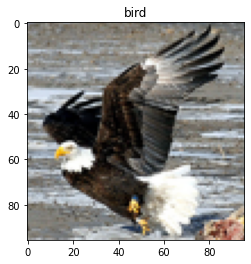

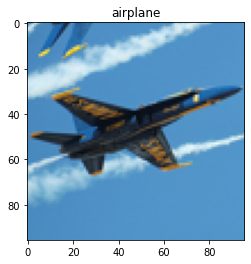

In [5]:
get_label_name = metadata.features['label'].int2str # 정답을 문자열로 반환

for image, label in train_ds.take(2) :
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label)) # 정답을 제목으로 표시

In [6]:
IMG_SIZE = 160 # 이미지를 모두 160x160으로 변경

def format_example(image, label) :
  image = tf.cast(image, tf.float32)
  image = (image/255.0)# - 1 # 정규화 (-1 ~ 1)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  return image, label

In [7]:
train = train_ds.map(format_example)
validation = val_ds.map(format_example)
test = test_ds.map(format_example)

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
for image_batch, label_batch in train_batches.take(1) :
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

### 베이스 모델 가져오기
-------------------------------------------------------------------------------

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, # FC계층(분류계층) 사용여부
    weights='imagenet',
    input_shape=IMG_SHAPE)

94781440/94765736 [==============================] - 1s 0us/step


### 모델 만들기
-------------------------------------------------------------------------------

In [11]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [12]:
base_model.trainale = False

In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [15]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [112]:
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = tf.keras.applications.resnet50.preprocess_input(x)
# x = base_model(x, training=True)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
# model = tf.keras.Model(inputs, outputs)

# inputs = tf.keras.applications.resnet50.preprocess_input

x = base_model.layers[-1].output
x = data_augmentation(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

In [113]:
model.summary()

Model: "model_117"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']     

### 모델 학습
--------------------------------------------------------------------------------

In [114]:
base_learning_rate = 0.0001
'''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [115]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

16/20 [=======================>......] - ETA: 0s - loss: 2.4955 - accuracy: 0.1000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 2s 113ms/step - loss: 2.4955 - accuracy: 0.1000


In [116]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 2.50
initial accuracy: 0.10


In [117]:
initial_epochs = 10

history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/10
125/125 [==============================] - 66s 520ms/step - loss: 0.2241 - accuracy: 0.9337 - val_loss: 2.4762 - val_accuracy: 0.1080
Epoch 2/10
125/125 [==============================] - 65s 515ms/step - loss: 0.0960 - accuracy: 0.9695 - val_loss: 1.1269 - val_accuracy: 0.6620
Epoch 3/10
125/125 [==============================] - 65s 518ms/step - loss: 0.0713 - accuracy: 0.9772 - val_loss: 0.9493 - val_accuracy: 0.7500
Epoch 4/10
125/125 [==============================] - 65s 517ms/step - loss: 0.0392 - accuracy: 0.9898 - val_loss: 0.7062 - val_accuracy: 0.8120
Epoch 5/10
125/125 [==============================] - 66s 521ms/step - loss: 0.0403 - accuracy: 0.9893 - val_loss: 0.7558 - val_accuracy: 0.8140
Epoch 6/10
125/125 [==============================] - 66s 521ms/step - loss: 0.0371 - accuracy: 0.9893 - val_loss: 0.7021 - val_accuracy: 0.8460
Epoch 7/10
125/125 [==============================] - 66s 518ms/step - loss: 0.0507 - accuracy: 0.9870 - val_loss: 0.8712 - val_ac

### 결과 시각화
---------------------------------------------------------------------

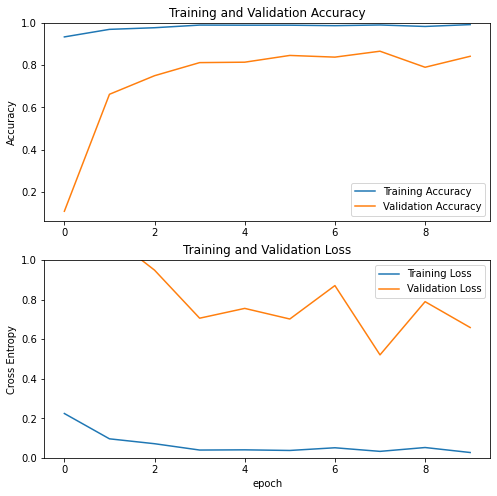

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [119]:
test_loss, test_acc = model.evaluate(test_batches, verbose=2)

print('\n테스트 정확도 :', test_acc)

16/16 - 2s - loss: 0.4814 - accuracy: 0.8900 - 2s/epoch - 144ms/step

테스트 정확도 : 0.8899999856948853


In [24]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

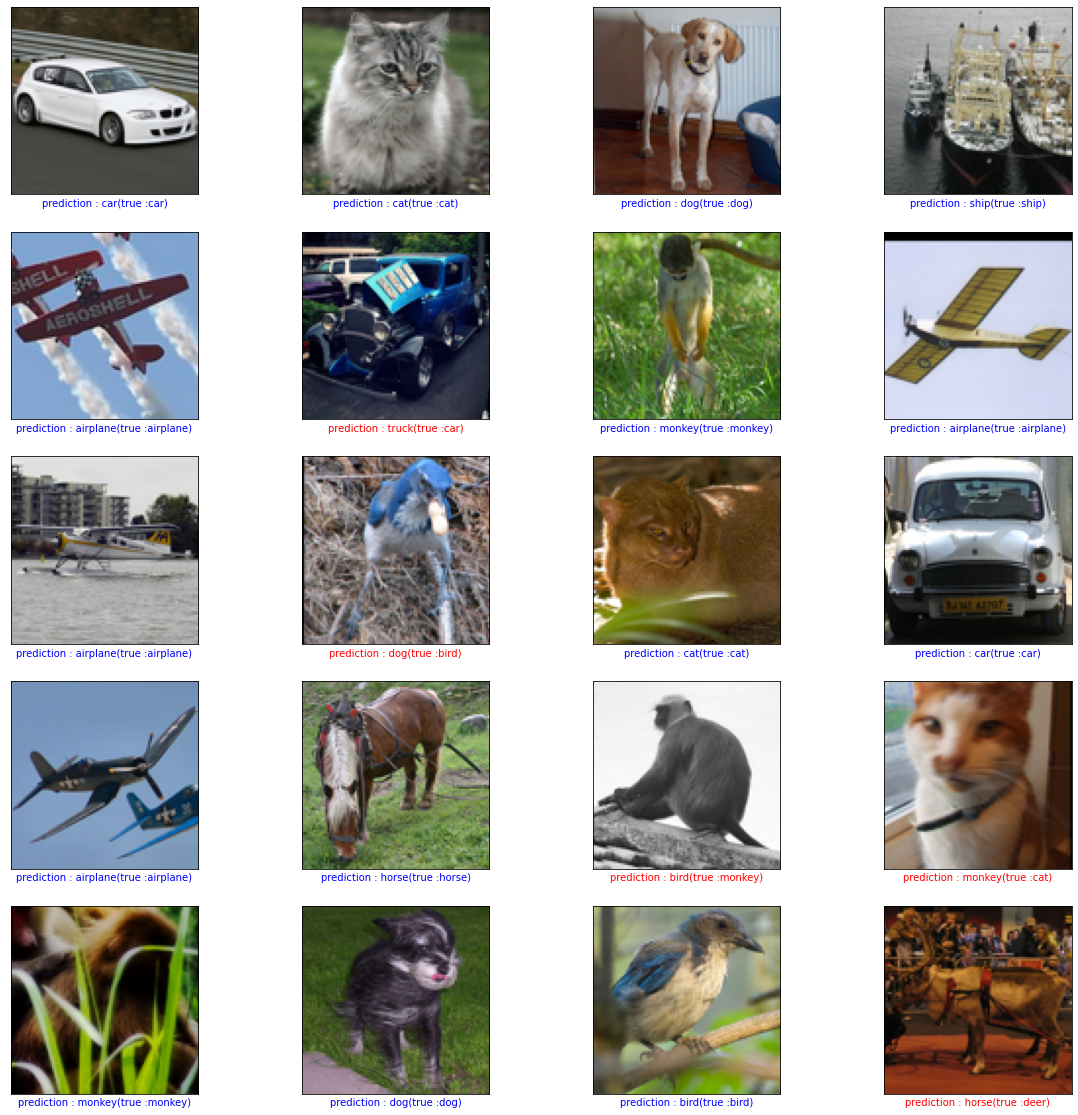

In [28]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

predictions = probability_model.predict(test_batches)
def plot_image(i, pred_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    pred_label = np.argmax(pred_array)
    
    if pred_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("prediction : {}(true :{})".format(class_names[pred_label],
                                class_names[true_label]),
                                color=color)
    
plt.figure(figsize=(20, 20))

for idx, (image, label) in enumerate(test_ds.take(20)) :
    plt.subplot(5, 4, idx+1)
    pred_array = predictions[idx]
    plot_image(idx, pred_array, label, image)
    
plt.show()

#### GradCAM
---------------------------------------------------------

In [29]:
pip install tf-explain

     |████████████████████████████████| 43 kB 1.5 MB/s 


/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


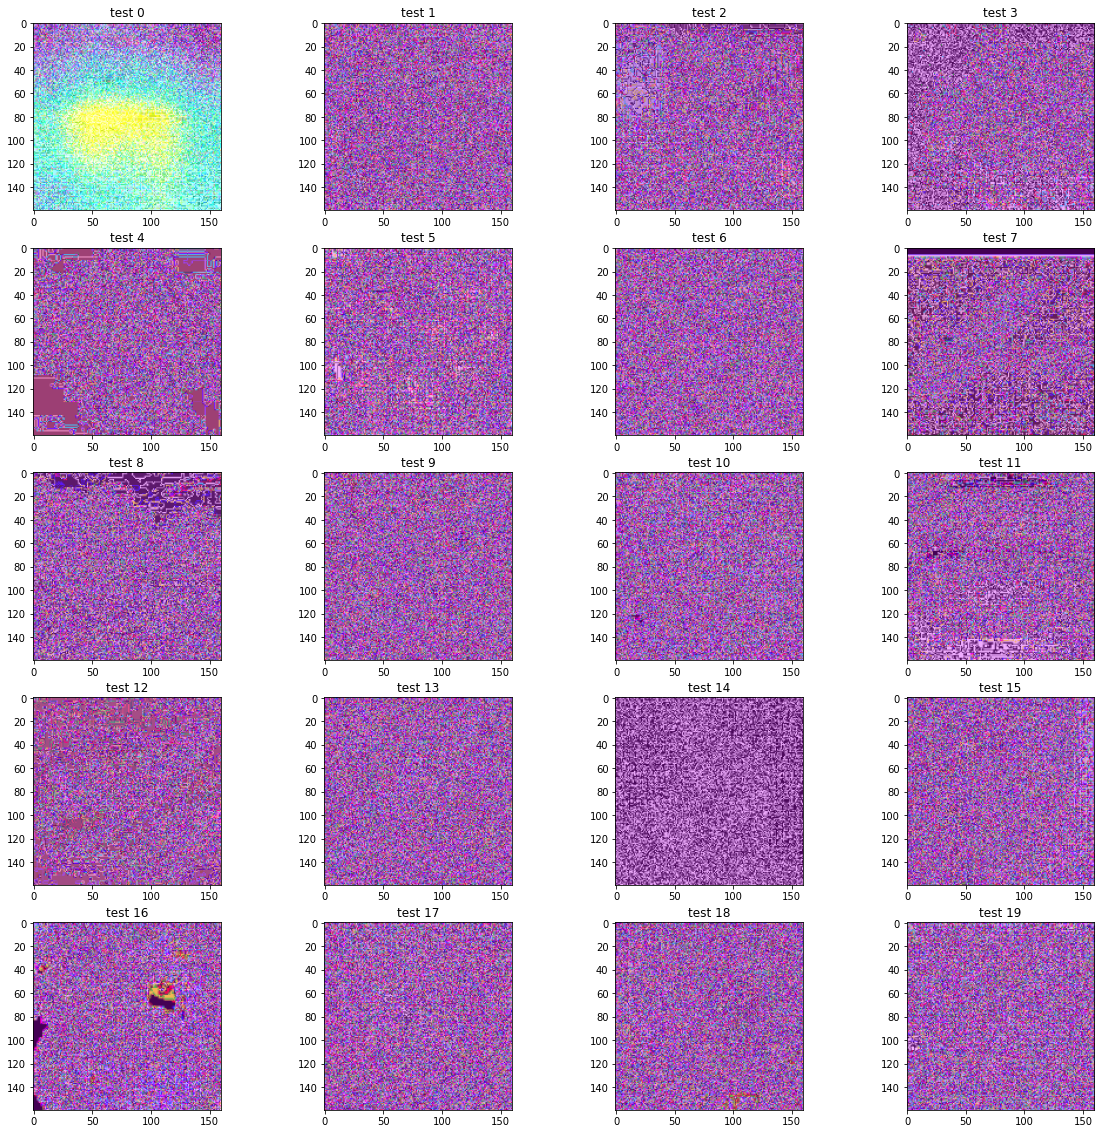

In [121]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from IPython.display import Image, display
from tf_explain.core.grad_cam import GradCAM
import PIL

plt.figure(figsize=(20, 20))

for idx, (img, label) in enumerate(test_ds.take(20)) :
    img = tf.image.resize(img, (160, 160))
    img = tf.keras.preprocessing.image.img_to_array(img)
    data = ([img], None)
    explainer =  GradCAM()
    grid = explainer.explain(data, model, class_index=label, layer_name='conv5_block3_3_conv')
    pil_image=PIL.Image.fromarray(grid)
    plt.subplot(5, 4, idx+1)
    plt.title(f'test {idx}')
    plt.imshow(pil_image)
plt.show()


## Result
--------------------------------------------------------------------
1. train
* loss : 0.0268
* accuracy : 0.9920
2. validation
* loss : 0.6591
* accuracy : 0.8420
3. Test
* loss : 0.4814
* accuracy : *0.8899999856948853*